<a href="https://colab.research.google.com/github/rhea24/cv-detecting-people/blob/main/Counting_People_in_Specific_Quadrants.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
!nvidia-smi

Wed Apr  2 02:29:10 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   49C    P0             27W /   70W |     476MiB /  15360MiB |     15%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [39]:
import torch
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0
torch:  2.6 ; cuda:  cu124


In [40]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [41]:
!pip install "ultralytics<=8.3.40"

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics 8.3.40 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 41.4/112.6 GB disk)


In [42]:
!pip install supervision

from IPython import display
display.clear_output()

import supervision as sv
print("supervision", sv.__version__)

supervision 0.25.1


In [43]:
!pip install supervision[assets] -q


In [44]:
from supervision.assets import download_assets, VideoAssets

download_assets(VideoAssets.MARKET_SQUARE)


market-square.mp4 asset download complete. 



'market-square.mp4'

In [45]:
import torch
from ultralytics import YOLO

model = YOLO('yolov8s.pt')


0: 1280x1056 38 persons, 3 handbags, 1 suitcase, 44.8ms
Speed: 15.2ms preprocess, 44.8ms inference, 1.5ms postprocess per image at shape (1, 3, 1280, 1056)


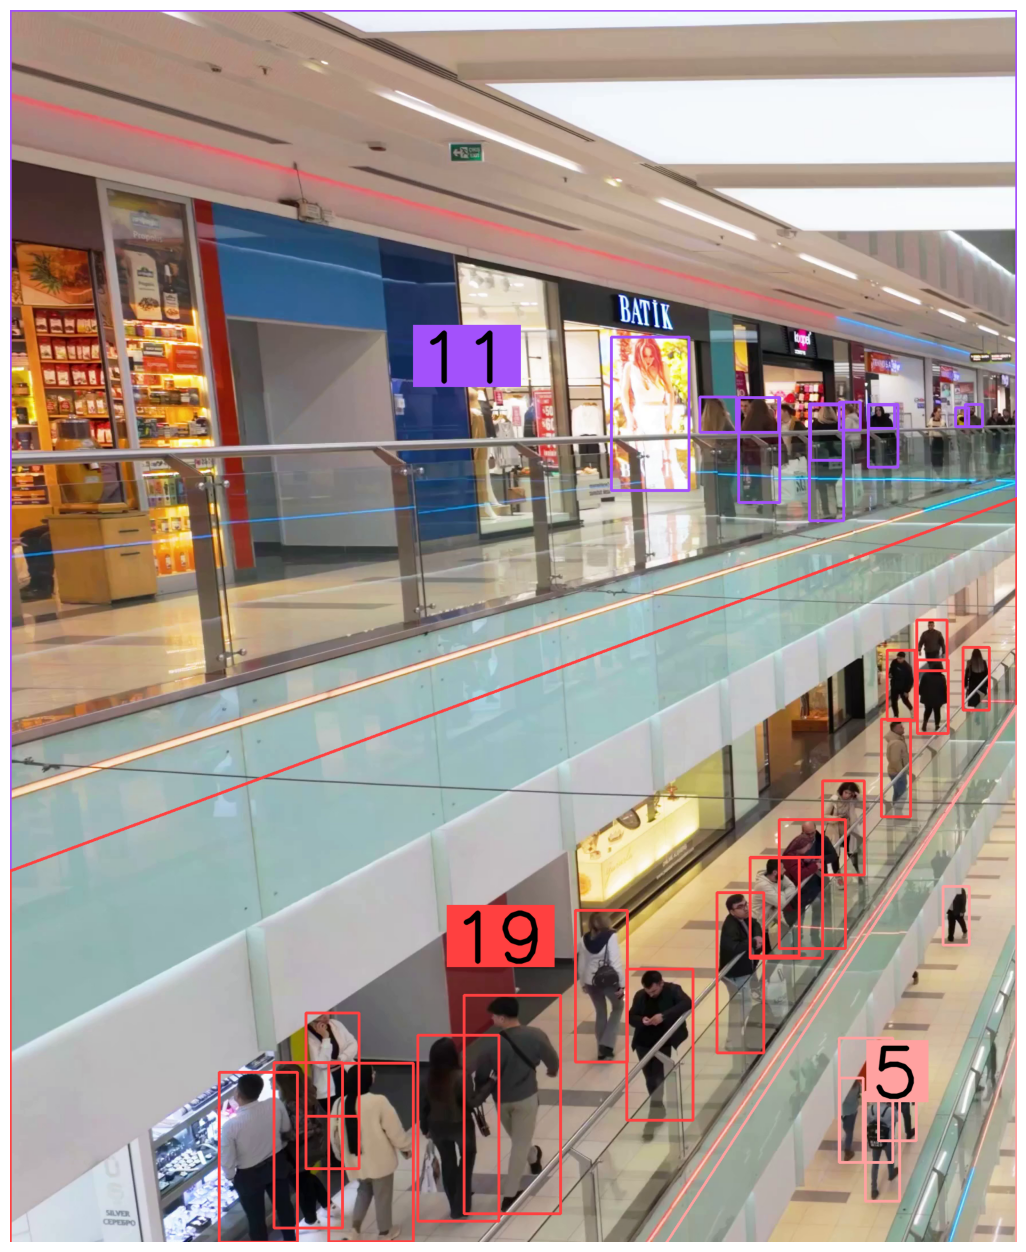

In [80]:
colors = sv.ColorPalette.DEFAULT
polygons = [
    np.array([
        [0, 0],
        [1763, 0],
        [1763, 856],
        [0, 1509]
    ], np.int32),
    np.array([
        [1763, 1220],
        [1137, 2180],
        [0, 2180],
        [0, 1509],
        [1763, 856]
    ], np.int32),
    np.array([
        [1763, 1220],
        [1137, 2180],
        [1763, 2180],
    ], np.int32),
]

zones = [sv.PolygonZone(polygon=polygon) for polygon in polygons]
zone_annotators = [
    sv.PolygonZoneAnnotator(
        zone=zone,
        color=colors.by_idx(index),
        thickness=4,
        text_thickness=8,
        text_scale=4
    )
    for index, zone
    in enumerate(zones)
]
box_annotators = [
    sv.BoxAnnotator(
        color=colors.by_idx(index),
        thickness=4,
    )
    for index
    in range(len(polygons))
]

# extract video frame
generator = sv.get_video_frames_generator("mall.mp4")
iterator = iter(generator)
frame = next(iterator)

# detect
results = model(frame, imgsz=1280)[0]
detections = sv.Detections.from_ultralytics(results)
detections = detections[(detections.class_id == 0) & (detections.confidence > 0.3)]

for zone, zone_annotator, box_annotator in zip(zones, zone_annotators, box_annotators):
    mask = zone.trigger(detections=detections)
    detections_filtered = detections[mask]
    frame = box_annotator.annotate(scene=frame, detections=detections_filtered)
    frame = zone_annotator.annotate(scene=frame)

%matplotlib inline
sv.plot_image(frame, (16, 16))

In [81]:
colors = sv.ColorPalette.DEFAULT
polygons = [
    np.array([
        [0, 0],
        [1763, 0],
        [1763, 856],
        [0, 1509]
    ], np.int32),
    np.array([
        [1763, 1220],
        [1137, 2180],
        [0, 2180],
        [0, 1509],
        [1763, 856]
    ], np.int32),
    np.array([
        [1763, 1220],
        [1137, 2180],
        [1763, 2180],
    ], np.int32),
]

zones = [sv.PolygonZone(polygon=polygon) for polygon in polygons]
zone_annotators = [
    sv.PolygonZoneAnnotator(
        zone=zone,
        color=colors.by_idx(index),
        thickness=6,
        text_thickness=8,
        text_scale=4
    )
    for index, zone
    in enumerate(zones)
]
box_annotators = [
    sv.BoxAnnotator(
        color=colors.by_idx(index),
        thickness=4,
    )
    for index
    in range(len(polygons))
]

def process_frame(frame: np.ndarray, i) -> np.ndarray:
    # detect
    results = model(frame, imgsz=1280)[0]
    detections = sv.Detections.from_ultralytics(results)
    detections = detections[(detections.class_id == 0) & (detections.confidence > 0.5)]

    for zone, zone_annotator, box_annotator in zip(zones, zone_annotators, box_annotators):
        mask = zone.trigger(detections=detections)
        detections_filtered = detections[mask]
        frame = box_annotator.annotate(scene=frame, detections=detections_filtered)
        frame = zone_annotator.annotate(scene=frame)

    return frame

sv.process_video(source_path="mall.mp4", target_path=f"{HOME}/mall-result.mp4", callback=process_frame)

display.clear_output()